In [2]:
import pandas as pd

#Load the data
df5  = pd.read_pickle('m5_example.pkl')
df5['ensemble'] = 'm5'

df6  = pd.read_pickle('m6_example.pkl')
df6['ensemble'] = 'm6'

df7  = pd.read_pickle('m7_example.pkl')
df7['ensemble'] = 'm7'

df8  = pd.read_pickle('m8_example.pkl')
df8['ensemble'] = 'm8'

df = pd.concat([df5,df6,df7,df8])





In [5]:
df

,temperature,label,level,precision,title,X,ensemble
0,286.025455,speedyone100yr_L2_52_RN_m5,L2,52_RN,EC Earth SST. ablco2=6,0,m5
1,286.725405,speedyone100yr_L2_52_RN_m5,L2,52_RN,EC Earth SST. ablco2=6,1,m5
2,286.979427,speedyone100yr_L2_52_RN_m5,L2,52_RN,EC Earth SST. ablco2=6,2,m5
3,287.126005,speedyone100yr_L2_52_RN_m5,L2,52_RN,EC Earth SST. ablco2=6,3,m5
4,287.245411,speedyone100yr_L2_52_RN_m5,L2,52_RN,EC Earth SST. ablco2=6,4,m5
...,...,...,...,...,...,...,...
36495,291.714313,speedyone100yr_L2_23_RN_m8_rerun,L2,23_RN,EC Earth SST. ablco2=6,36495,m8
36496,291.656067,speedyone100yr_L2_23_RN_m8_rerun,L2,23_RN,EC Earth SST. ablco2=6,36496,m8
36497,291.654748,speedyone100yr_L2_23_RN_m8_rerun,L2,23_RN,EC Earth SST. ablco2=6,36497,m8
36498,291.621212,speedyone100yr_L2_23_RN_m8_rerun,L2,23_RN,EC Earth SST. ablco2=6,36498,m8


Average errors table:


,index,temperature,X,merge_column,temperature_52RN,X_52RN,MBE,MAE
precision,,,,,,,,
10_RN,148.5,290.904266,18249.5,18249.5,290.939319,18249.5,-0.035053,0.046126
10_SR,149.5,290.957361,18249.5,18249.5,290.939319,18249.5,0.018042,0.034830
23_RN,150.5,290.939509,18249.5,18249.5,290.939319,18249.5,0.000190,0.025210


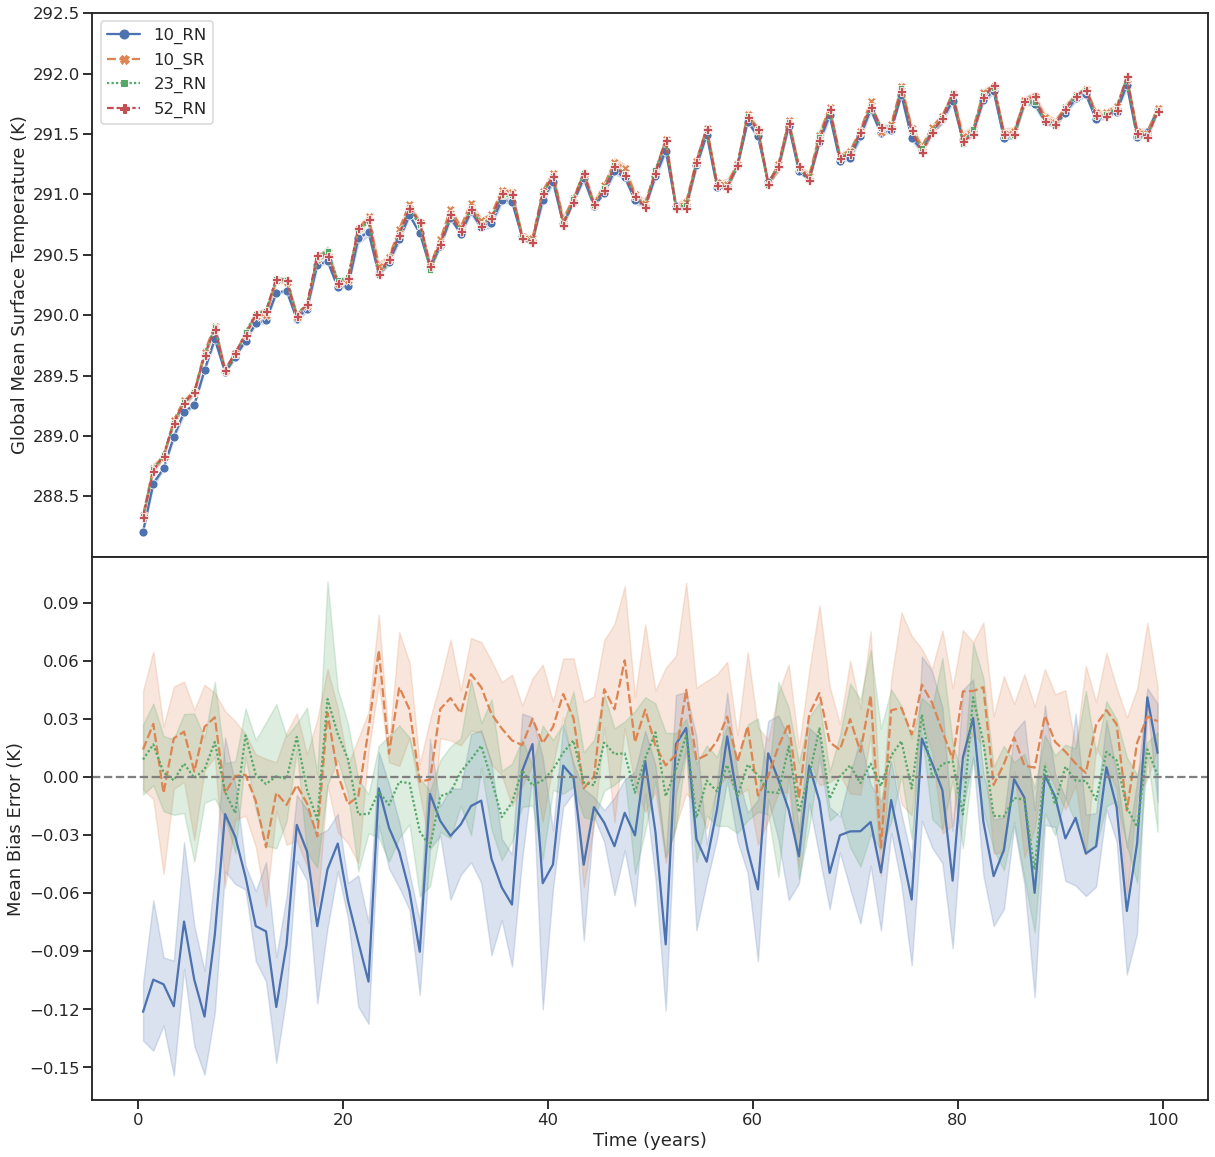

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

# def calculate_residuals(df):
    
    
#     #Get a ground truth that all others will be compared against. i.e. 52 RNe
#     df_truth = df.query('precision == "52_RN" ')[['X', 'temperature']]
#     df_truth['merge_column'] = df_truth['X'].astype(int) #Create a column to merge on.     #Note integer conversions are needed for join

    
#     #Get the others
#     df_rest = df.query('precision != "52_RN" ').reset_index(drop=True) #reset index to avoid SettingWithCopyWarning
#     df_rest['merge_column'] = df_rest['X'].astype('int') 
    

#     #Rejoin - maybe a more efficient way to do this?
#     df_join = pd.merge(df_rest,df_truth,how='left',on='merge_column', suffixes=(None, 'truth'))
    
#     #Get residual
#     df_join['MBE'] = df_join['temperature'] - df_join['temperaturetruth']
#     df_join['MAE'] = abs(df_join['temperature'] - df_join['temperaturetruth'])
    
#     print ('Average:')
#     display(df_join.groupby(by=["precision"]).mean()) 
#     display(len(df_join))
#     return df_join


def process_single_example(df,time_period):
    
    
    
    df_averaged = df.groupby([df.index//time_period, 'label','level','precision', 'title'],as_index=False).mean()
    
    #display(df_averaged)
    
    df52 = df_averaged.query('precision == "52_RN"').copy()
    dfrest = df_averaged.query('precision != "52_RN"').copy()

    df52['merge_column'] = df52['X'].astype(int) #Create a column to merge on.  
    dfrest['merge_column'] = dfrest['X'].astype(int) #Create a column to merge on.  



    #merge
    df_join = pd.merge(dfrest,df52,how='left', on='merge_column', suffixes=(None, '_52RN'))
    df_join['MBE'] = df_join['temperature'] - df_join['temperature_52RN']
    df_join['MAE'] = abs(df_join['temperature'] - df_join['temperature_52RN'])
    
    #display(df_join.groupby(by='precision').mean())

    #display(df_join)
    
    return df_join











def plot_timeseries(df,time_period,error_metric,error_time_scaling,savefig):


    #Set up plot figure
    
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(h,w))
    
    
    
    
    

    #Part A: TIMESERIES
    
    # Take an average over time_period number of days. Set time_period = 365 for yearly average
    df_averaged = df.groupby([df.index//time_period, 'label','level','precision', 'title'],as_index=False).mean()
    df_averaged['years']  = df_averaged.X/time_period
    p = sns.lineplot(data=df_averaged, x="years", y='temperature', hue="precision",ax=ax1,style='precision',markers=True)
    
    
    
    #Part B: Errors
    dfs = []
    for m in np.unique(df.ensemble):
        df_error = process_single_example(df.query(f'ensemble == "{m}"'),time_period*error_time_scaling)
        dfs.append(df_error)
    df_error = pd.concat(dfs).reset_index()    
    print ('Average errors table:')
    display(df_error.groupby(by='precision').mean())
    df_error['years']  = df_error.X/time_period
    q = sns.lineplot(data=df_error, x="years", y=error_metric, hue="precision",ax=ax2,style='precision',markers=False,legend=False)

    
    #Config
    plt.subplots_adjust(wspace=0.1, hspace=0)

    ax1.set_ylabel("Global Mean Surface Temperature (K)")
    ax2.set_ylabel("Mean Bias Error (K)")

    
    ax2.set_xlabel("Time (years)")
  
    ax2.axhline(0.0, c='0.5', linestyle='--')
    
    
    #ax2.set_yscale('log')
    
    ax1.set_ylim(288,292.5)
    #ax2.set_ylim(-0.1,0.06)


    #labels = ax2.get_yticklabels()
    #print(labels)
    # remove the first and the last labels
    #labels[0] = ""
    # set these new labels
    #ax2.set_yticklabels(labels)
    #print(ax2.get_yticklabels())
   # plt.setp(a.get_yticklabels()[-1], visible=False)
    ax1.yaxis.set_major_locator(MaxNLocator(prune='lower'))
    ax2.yaxis.set_major_locator(MaxNLocator(prune='upper'))


    #Other config
    ax1.legend().set_title(None)
    
    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)
    
    
    
plot_timeseries(df,time_period=365,error_metric='MBE',error_time_scaling=1,savefig=None)
#plot_timeseries(df,time_period=365,error_metric='MBE',error_time_scaling=10,savefig=None)


# What if we just load one member?

In [75]:
df6  = pd.read_pickle('m5_example.pkl')


def process_single_example(df):
    
    df_averaged = df.groupby([df.index//time_period, 'label','level','precision', 'title'],as_index=False).mean()
    
    
    df52 = df_averaged.query('precision == "52_RN"').copy()
    dfrest = df_averaged.query('precision != "52_RN"').copy()

    df52['merge_column'] = df52['X'].astype(int) #Create a column to merge on.  
    dfrest['merge_column'] = dfrest['X'].astype(int) #Create a column to merge on.  



    #merge
    df_join = pd.merge(dfrest,df52,how='left', on='merge_column', suffixes=(None, '_52RN'))
    df_join['MBE'] = df_join['temperature'] - df_join['temperature_52RN']
    df_join['MAE'] = abs(df_join['temperature'] - df_join['temperature_52RN'])
    
    display(df_join.groupby(by='precision').mean())


In [76]:
df5 = pd.read_pickle('m5_example.pkl')
process_single_example(df5)

,temperature,X,merge_column,temperature_52RN,X_52RN,MBE,MAE
precision,,,,,,,
10_RN,290.899987,18249.5,18249.5,290.944332,18249.5,-0.044345,0.051589
10_SR,290.958596,18249.5,18249.5,290.944332,18249.5,0.014264,0.033596
23_RN,290.940689,18249.5,18249.5,290.944332,18249.5,-0.003643,0.027036


In [77]:
df6 = pd.read_pickle('m6_example.pkl')
process_single_example(df6)

,temperature,X,merge_column,temperature_52RN,X_52RN,MBE,MAE
precision,,,,,,,
10_RN,290.901412,18249.5,18249.5,290.94025,18249.5,-0.038839,0.044088
10_SR,290.963709,18249.5,18249.5,290.94025,18249.5,0.023459,0.034519
23_RN,290.941315,18249.5,18249.5,290.94025,18249.5,0.001065,0.024896


In [78]:
df7 = pd.read_pickle('m7_example.pkl')
process_single_example(df7)

,temperature,X,merge_column,temperature_52RN,X_52RN,MBE,MAE
precision,,,,,,,
10_RN,290.901086,18249.5,18249.5,290.93587,18249.5,-0.034784,0.043336
10_SR,290.966847,18249.5,18249.5,290.93587,18249.5,0.030978,0.040696
23_RN,290.939314,18249.5,18249.5,290.93587,18249.5,0.003444,0.023897


In [82]:
process_single_example(df.query('ensemble == "m6"'))

,temperature,X,merge_column,temperature_52RN,X_52RN,MBE,MAE
precision,,,,,,,
10_RN,290.901412,18249.5,18249.5,290.94025,18249.5,-0.038839,0.044088
10_SR,290.963709,18249.5,18249.5,290.94025,18249.5,0.023459,0.034519
23_RN,290.941315,18249.5,18249.5,290.94025,18249.5,0.001065,0.024896
